In [8]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler

MERGED_DATA_DIR = "../../data/merged data"
OUTPUT_DIR = "../../output/assumption"

# Load the dataset
tnp_20 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2020", "merged_tnp_data.csv"))
tnp_19 = pd.read_csv(os.path.join(MERGED_DATA_DIR, "2019", "merged_tnp_data.csv"))

In [9]:
# 添加年份指示变量
tnp_20["is_2020"] = 1
tnp_19["is_2020"] = 0

scaler = StandardScaler()
cols_to_scale = ["daily_bus_rides", "rides"]
tnp_20[cols_to_scale] = scaler.fit_transform(tnp_20[cols_to_scale])
tnp_19[cols_to_scale] = scaler.fit_transform(tnp_19[cols_to_scale])

# 拼接数据
merged_df = pd.concat([tnp_20, tnp_19], ignore_index=True)
merged_df["price"] = merged_df["fare"] + merged_df["additional_charges"]
# merged_df['price'] = np.log1p(merged_df['price'])

# 确保日期变量是 datetime 类型（后续 RDiT 会用到）
merged_df["trip_start_date"] = pd.to_datetime(merged_df["trip_start_date"])

# 创建工作日虚拟变量，drop_first=True 是为了避免虚拟变量陷阱
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='dow', drop_first=True)

# 合并到原始数据中
merged_df = pd.concat([merged_df, day_dummies], axis=1)

# 创建地区虚拟变量，drop_first=True 是为了避免虚拟变量陷阱
area_dummies = pd.get_dummies(merged_df['area_type'], prefix='at', drop_first=True)

# 合并到原始数据中
merged_df = pd.concat([merged_df, area_dummies], axis=1)

In [10]:
print("数据总行数：", len(merged_df))
print("是否有NaN：", merged_df["price"].isna().sum())
print("时间列范围：", merged_df["trip_start_date"].min(), merged_df["trip_start_date"].max())

数据总行数： 3187906
是否有NaN： 0
时间列范围： 2018-12-10 00:00:00 2020-02-05 00:00:00


In [11]:
trip_controls = [
    "trip_seconds", "trip_miles", "trip_during_peak"
]

weather_controls = [
    "Avg_Temp_C", "Precipitation_mm",
    "Snowfall_mm", "Avg_Wind_Speed_mps",
]

substitutes_controls = [
    # "total_rides", "taxi",
    "rides", "daily_bus_rides", "taxi",
]

day_of_week_controls = ["dow_1", "dow_2", "dow_3", "dow_4"]

area_type_controls = ["at_1", "at_2"]

control_vars = (
    trip_controls
    + weather_controls
    + substitutes_controls
    + day_of_week_controls
    + area_type_controls
)

merged_df_0 = merged_df[merged_df["Cluster"] == 0]
merged_df_1 = merged_df[merged_df["Cluster"] == 1]
merged_df_2 = merged_df[merged_df["Cluster"] == 2]

In [12]:
def estimate_dif_in_rdit(
    df: pd.DataFrame,
    outcome: str,
    time_var: str,
    treat_year_var: str,
    cutoff_date,
    placebo_cutoff_date="2019-01-07",
    heterogeneity_vars: list = None,
    covariates: list = None,
    trend_order: int = 1,
    bandwidth: int = 29
):
    """
    估计Dif-in-RDiT模型，支持多个异质性变量（连续或虚拟变量）

    数学模型：
    Y_{it} = β0 + β1·Post_t + β2·TreatYear_i + β3·(Post_t·TreatYear_i)
           + f(TFC_t) + f(TFC_t)·Post_t + f(TFC_t)·TreatYear_i + f(TFC_t)·Post_t·TreatYear_i
           + ∑ δ_k·H_{ik} + ∑ θ_k·(Post_t·H_{ik}) + γ^T X + u_{it}
    """

    import pandas as pd
    import numpy as np
    import statsmodels.formula.api as smf

    df = df.copy()
    df[time_var] = pd.to_datetime(df[time_var])
    cutoff_date = pd.to_datetime(cutoff_date)
    placebo_cutoff_date = pd.to_datetime(placebo_cutoff_date)

    df["cutoff_for_row"] = df[treat_year_var].apply(
        lambda x: cutoff_date if x == 1 else placebo_cutoff_date
    )
    df["days_from_cutoff"] = (df[time_var] - df["cutoff_for_row"]).dt.days
    df = df[df["days_from_cutoff"].between(-bandwidth, bandwidth)]

    df["post_cutoff"] = (df["days_from_cutoff"] >= 0).astype(int)
    df["post_treat"] = df["post_cutoff"] * df[treat_year_var]

    trend_terms = []
    for i in range(1, trend_order + 1):
        base = f"days_from_cutoff_pow{i}"
        df[base] = df["days_from_cutoff"] ** i

        post = f"{base}_x_post"
        treat = f"{base}_x_treat"
        post_treat = f"{base}_x_post_treat"

        df[post] = df[base] * df["post_cutoff"]
        df[treat] = df[base] * df[treat_year_var]
        df[post_treat] = df[base] * df["post_cutoff"] * df[treat_year_var]

        trend_terms += [base, post, treat, post_treat]

    rhs = ["post_cutoff", treat_year_var, "post_treat"] + trend_terms

    if covariates:
        rhs += covariates

    interaction_terms = []
    if heterogeneity_vars:
        for var in heterogeneity_vars:
            rhs.append(var)  # H_k
            inter = f"post_cutoff:{var}"  # Post_t * H_k
            rhs.append(inter)
            interaction_terms.append(inter)

    formula = f"{outcome} ~ " + " + ".join(rhs)
    model = smf.ols(formula=formula, data=df).fit(cov_type='HC3')

    summary_df = model.summary2().tables[1].copy()
    summary_df.columns = summary_df.columns.astype(str)
    summary_df = summary_df.rename(columns={
        "Coef.": "coef",
        "Std.Err.": "std_err",
        "P>|t|": "p_value",
        "[0.025": "ci_lower",
        "0.975]": "ci_upper"
    })
    summary_df["variable"] = summary_df.index
    summary_df.reset_index(drop=True, inplace=True)
    print(model.rsquared)

    return summary_df

# Multiple Bandwidths Result

In [13]:
def estimate_bandwidth_robustness_table(
    df: pd.DataFrame,
    outcome: str,
    time_var: str,
    treat_year_var: str,
    cutoff_date,
    placebo_cutoff_date="2019-01-07",
    covariates: list = None,
    heterogeneity_vars: list = None,
    trend_order: int = 1,
    bandwidths: list = [3, 6, 9, 12, 15, 30],
    coef_name: str = "post_treat"
):
    """
    遍历多个 bandwidth，输出回归结果表格（用于导出 TeX）
    """
    results = []

    for bw in bandwidths:
        summary = estimate_dif_in_rdit(
            df=df,
            outcome=outcome,
            time_var=time_var,
            treat_year_var=treat_year_var,
            cutoff_date=cutoff_date,
            placebo_cutoff_date=placebo_cutoff_date,
            covariates=covariates,
            heterogeneity_vars=heterogeneity_vars,
            trend_order=trend_order,
            bandwidth=bw
        )

        row = summary[summary["variable"] == coef_name].copy()
        if not row.empty:
            row["group"] = f"±{bw} days"
            results.append(row)

    if results:
        return pd.concat(results, ignore_index=True)
    else:
        return pd.DataFrame()

In [14]:
def export_custom_bandwidth_heterogeneity_table_to_tex(
    summary_df: pd.DataFrame,
    file_path: str = "output/custom_bw_hetero_table.tex",
    sig_levels: list = [0.1, 0.05, 0.01],
    caption: str = "Estimated effects across income groups and bandwidths.",
    label: str = "tab:custom_bw_hetero",
    group_order: list = None,
    bandwidth_order: list = None,
    bandwidth_label_prefix: str = "±"
):
    """
    生成 LaTeX 表格，行是带宽，列是组，表格内容以 makecell 包装支持单元格内换行。
    """
    import os
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    def get_stars(p):
        if p < sig_levels[2]: return '***'
        elif p < sig_levels[1]: return '**'
        elif p < sig_levels[0]: return '*'
        return ''

    df = summary_df[summary_df["variable"] == "post_treat"].copy()

    if bandwidth_order is None:
        bandwidth_order = sorted(df["bandwidth"].dropna().unique())
    if group_order is None:
        group_order = df["hetero_group"].dropna().unique().tolist()

    tex_lines = [
        "\\begin{table}[H]\\centering",
        "\\renewcommand{\\arraystretch}{1.3}",
        "\\caption{" + caption + "}",
        "\\label{" + label + "}",
        "\\footnotesize",
        "\\begin{tabular}{l" + "c" * len(group_order) + "}",
        "\\toprule",
        "Bandwidth & " + " & ".join(group_order) + " \\\\",
        "\\midrule"
    ]

    for bw in bandwidth_order:
        row = [f"{bandwidth_label_prefix}{int(bw)} days"]
        for grp in group_order:
            sub = df[(df["bandwidth"] == bw) & (df["hetero_group"] == grp)]
            if not sub.empty:
                r = sub.iloc[0]
                cell = f"\\makecell{{{r['coef']:.3f}{get_stars(r['P>|z|'])} \\\\ ({r['std_err']:.3f})}}"
            else:
                cell = "--"
            row.append(cell)
        tex_lines.append(" & ".join(row) + " \\\\")

    tex_lines += [
        "\\bottomrule",
        "\\end{tabular}",
        "\\vspace{0.5em}",
        "\\begin{minipage}{0.95\\textwidth}\\footnotesize\\textit{Notes:} This table reports the estimated treatment effects under different bandwidths around the policy cutoff. Each cell shows the coefficient and the robust standard error (in parentheses). * $p<0.1$, ** $p<0.05$, *** $p<0.01$.\\end{minipage}",
        "\\end{table}"
    ]

    with open(file_path, "w", encoding="utf-8") as f:
        f.write("\n".join(tex_lines))

    print(f"LaTeX table saved to: {file_path}")


In [15]:
# 假设你的数据已加载为 df
summary_pooled = estimate_bandwidth_robustness_table(
    df=merged_df,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    covariates=control_vars,  # 可选
    heterogeneity_vars=None,  # 可选
    trend_order=1,
    bandwidths=[5, 7, 10, 15, 30],
    coef_name="post_treat"
)

summary_low = estimate_bandwidth_robustness_table(
    df=merged_df_0,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    covariates=control_vars,  # 可选
    heterogeneity_vars=None,  # 可选
    trend_order=1,
    bandwidths=[5, 7, 10, 15, 30],
    coef_name="post_treat"
)

summary_high = estimate_bandwidth_robustness_table(
    df=merged_df_1,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    covariates=control_vars,  # 可选
    heterogeneity_vars=None,  # 可选
    trend_order=1,
    bandwidths=[5, 7, 10, 15, 30],
    coef_name="post_treat"
)

summary_mid = estimate_bandwidth_robustness_table(
    df=merged_df_2,
    outcome="price",
    time_var="trip_start_date",
    treat_year_var="is_2020",
    cutoff_date="2020-01-06",
    placebo_cutoff_date="2019-01-07",
    covariates=control_vars,  # 可选
    heterogeneity_vars=None,  # 可选
    trend_order=1,
    bandwidths=[5, 7, 10, 15, 30],
    coef_name="post_treat"
)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '


0.7981142362064728
0.7902773923834211
0.7870883790003316
0.7795886814191689
0.7536911221438362
0.8253810188066867
0.8084948656334816
0.8130596144175579
0.8139738498096765
0.8025079479672652
0.787153586947312
0.7787404934838524
0.7758415137966937
0.7688939921582473
0.7432783064134848
0.8123032116833468
0.8068587263097592
0.803574069943555
0.7951670006904098
0.7662640999133898


In [ ]:
rows = []
for label, df in [("Pooled", summary_pooled), ("Low Income", summary_low), ("Mid Income", summary_mid), ("High Income", summary_high)]:
    df = df[df["variable"] == "post_treat"].copy()
    df["hetero_group"] = label  # 给分组打标签
    df["bandwidth"] = df["group"].str.extract(r'(\d+)').astype(float)  # 从 group 中提取 ±X days 中的 X
    rows.append(df)

summary_df = pd.concat(rows, ignore_index=True)
print(summary_df.head())

export_custom_bandwidth_heterogeneity_table_to_tex(
    summary_df=summary_df,
    file_path="../../output/robustness/rdit_across_bandwidth.tex",
    caption="Bandwidth Robustness Checks across Income Groups",
    label="tab:bw_hetero_income",
    group_order=["Pooled", "Low Income", "Mid Income", "High Income"],
    bandwidth_order=[5, 7, 10, 15, 30]
)

       coef   std_err             z  P>|z|  ci_lower  ci_upper    variable  \
0  2.869010  0.000188  15285.435433    0.0  2.868642  2.869378  post_treat   
1  2.105546  0.044334     47.492891    0.0  2.018653  2.192438  post_treat   
2  1.900241  0.017966    105.770398    0.0  1.865029  1.935453  post_treat   
3  1.931127  0.014045    137.496271    0.0  1.903599  1.958654  post_treat   
4  1.966910  0.009706    202.640358    0.0  1.947886  1.985935  post_treat   

      group hetero_group  bandwidth  
0   ±5 days       Pooled        5.0  
1   ±7 days       Pooled        7.0  
2  ±10 days       Pooled       10.0  
3  ±15 days       Pooled       15.0  
4  ±30 days       Pooled       30.0  
LaTeX table saved to: ../../output/robustness/rdit_across_bandwidth_quad_linear.tex


In [17]:
import matplotlib.pyplot as plt

def plot_bandwidth_sensitivity_from_summary(
    summary_df: pd.DataFrame,
    group: str = "Pooled",
    title: str = "Estimated Discontinuity in Price\nat Varying Bandwidths of Treatment",
    ylabel: str = "Estimated Jump in Price",
    xlabel: str = "Bandwidth (± days)",
    figsize=(6, 4),
    save_path=None
):
    """
    根据 summary_df（含 bandwidth、coef、std_err）绘图，可指定 group。
    """
    df = summary_df[(summary_df["variable"] == "post_treat") & (summary_df["hetero_group"] == group)].copy()
    df = df.sort_values("bandwidth")

    # 计算置信区间
    df["ci_lower"] = df["coef"] - 1.96 * df["std_err"]
    df["ci_upper"] = df["coef"] + 1.96 * df["std_err"]

    plt.figure(figsize=figsize)
    plt.errorbar(df["bandwidth"], df["coef"],
                 yerr=[df["coef"] - df["ci_lower"], df["ci_upper"] - df["coef"]],
                 fmt='o', color='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved figure to {save_path}")

    plt.show()


       coef   std_err             z  P>|z|  ci_lower  ci_upper    variable  \
0  2.869010  0.000188  15285.435433    0.0  2.868642  2.869378  post_treat   
1  2.105546  0.044334     47.492891    0.0  2.018653  2.192438  post_treat   
2  1.900241  0.017966    105.770398    0.0  1.865029  1.935453  post_treat   
3  1.931127  0.014045    137.496271    0.0  1.903599  1.958654  post_treat   
4  1.966910  0.009706    202.640358    0.0  1.947886  1.985935  post_treat   

      group hetero_group  bandwidth  
0   ±5 days       Pooled        5.0  
1   ±7 days       Pooled        7.0  
2  ±10 days       Pooled       10.0  
3  ±15 days       Pooled       15.0  
4  ±30 days       Pooled       30.0  
Saved figure to ../../output/robustness/pooled_estimate_across_bandwidth.pdf


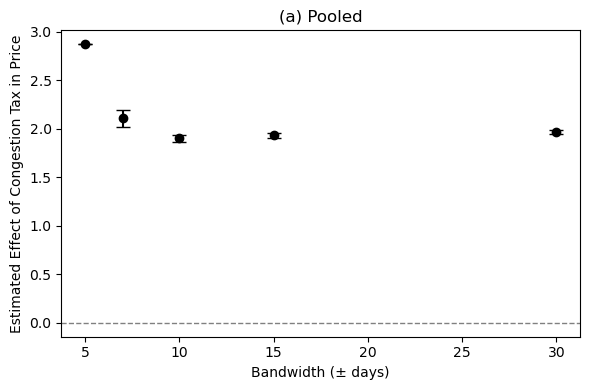

Saved figure to ../../output/robustness/low_estimate_across_bandwidth.pdf


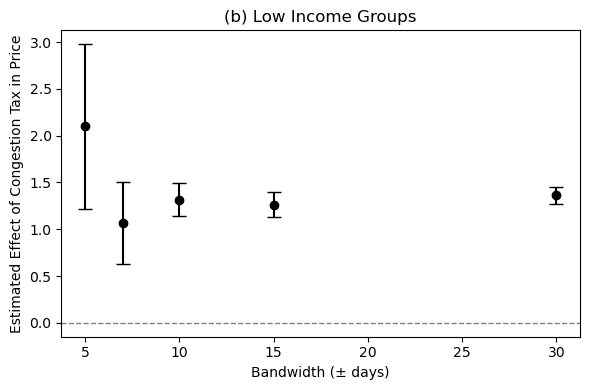

Saved figure to ../../output/robustness/mid_estimate_across_bandwidth.pdf


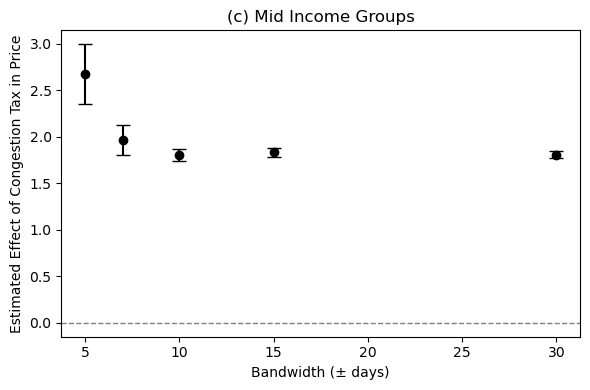

Saved figure to ../../output/robustness/high_estimate_across_bandwidth.pdf


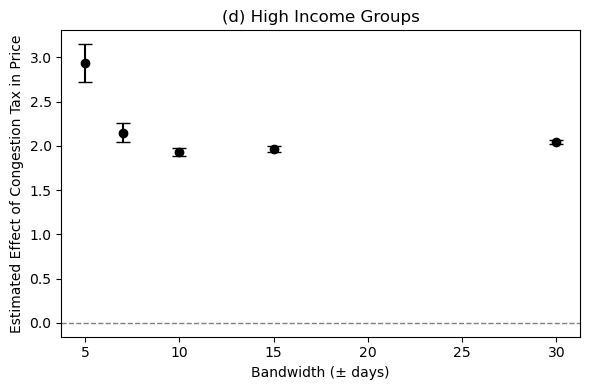

In [18]:
print(summary_df.head())

plot_bandwidth_sensitivity_from_summary(
    summary_df=summary_df,
    group="Pooled",  # 可换成 "Low Income", "High Income", "Mid Income"
    title="(a) Pooled",
    ylabel="Estimated Effect of Congestion Tax in Price",
    save_path="../../output/robustness/pooled_estimate_across_bandwidth.pdf"
)

plot_bandwidth_sensitivity_from_summary(
    summary_df=summary_df,
    group="Low Income",  # 可换成 "Low Income", "High Income", "Mid Income"
    title="(b) Low Income Groups",
    ylabel="Estimated Effect of Congestion Tax in Price",
    save_path="../../output/robustness/low_estimate_across_bandwidth.pdf"
)

plot_bandwidth_sensitivity_from_summary(
    summary_df=summary_df,
    group="Mid Income",  # 可换成 "Low Income", "High Income", "Mid Income"
    title="(c) Mid Income Groups",
    ylabel="Estimated Effect of Congestion Tax in Price",
    save_path="../../output/robustness/mid_estimate_across_bandwidth.pdf"
)

plot_bandwidth_sensitivity_from_summary(
    summary_df=summary_df,
    group="High Income",  # 可换成 "Low Income", "High Income", "Mid Income"
    title="(d) High Income Groups",
    ylabel="Estimated Effect of Congestion Tax in Price",
    save_path="../../output/robustness/high_estimate_across_bandwidth.pdf"
)
